In [ ]:
# Import the necessaries libraries
import plotly.offline as pyo
import plotly.graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

#import plotly.graph_objects as go
#import chart_studio.plotly as py

import numpy as np
import pandas as pd

from binance.client import Client
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM
from keras.metrics import MeanSquaredError
from keras.layers import Dropout
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

In [ ]:
# Binance API Key
api_key = 'xxxxxxxxxxxxxxx'
api_secret = 'xxxxxxxxxxxxxxxx'
#Historical data interval -  Daily
interval = '1d' # This can be adjusted to minutes, seconds or tick
data_dir = "./data/"

In [ ]:
# Below method is the code to generate the input data to the model and the output data

# all_data - data retrieved from the exchange (Binance)
# time_steps - number of look back, eg 10 days closing price look back
# for_preiods - output of the model, eg 1 day cloing price

def ts_train_test_normalize(all_data, time_steps, for_periods):
    '''
    input:
      data: dataframe with dates and price data
      time_steps - number of look back, eg 10 days closing price look back
      for_preiods - output of the model, eg 1 day cloing price
    output:
      X_train, y_train: data from 2018/1/1-2021/12/31
      X_test:  data from 2022 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2021'].iloc[:, 4:5].values
    ts_test = all_data['2022':].iloc[:, 4:5].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data

    sc = MinMaxScaler(feature_range=(0, 1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps, ts_train_len - 1):
        X_train.append(ts_train_scaled[i - time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i + for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    inputs = pd.concat((all_data["close"][:'2021'], all_data["close"]['2022':]), axis=0).values
    inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1, 1)
    #print(inputs)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i - time_steps:i, 0])


    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc

In [5]:
def GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model


    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))

    # Third GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=1))
    # Compiling the RNN
    my_GRU_model.compile(loss="mean_squared_error",optimizer="adam")
    # Fitting to the training set
    my_GRU_model.fit(X_train, y_train, epochs=50, batch_size=150, verbose=0)


    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

In [48]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model

    #SGD = gradient_descent_v2.SGD(...)
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=1))

    # Compiling
    my_LSTM_model.compile(loss="mean_squared_error",optimizer="adam")
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [6]:
def predict_future_days(all_data, time_steps,  pred_days, model, sc):

    test_data = all_data['2022':].iloc[:, 4:5].values
    x_input = test_data[len(test_data) - time_steps:].reshape(1, -1)
    print("Before transformation Input data for prediction")
    print(x_input)
    input = x_input.reshape(-1, 1)
    input = sc.transform(input)
    print("Input data for prediction")
    print(input)
    # Preparing X_test
    X_test = []
    for i in range(0, len(input)):
        X_test.append(input[i, 0])
    print(X_test)

    temp_input = X_test
    print("input {} ".format(temp_input))
    x_input = input
    #
    lst_output = []
    n_steps = time_steps
    i = 0
    #pred_days = 30
    while (i < pred_days):

        if (len(temp_input) > time_steps):

            x_input = np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1, -1)
            #x_input = sc.transform(x_input)
            x_input = x_input.reshape((1, n_steps, 1))

            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            print(temp_input)

            lst_output.extend(yhat.tolist())
            i = i + 1

        else:

            x_input = x_input.reshape((1, n_steps, 1))
            print("{} day input {}".format(i, x_input))
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())

            lst_output.extend(yhat.tolist())
            i = i + 1
    temp_mat = np.empty(pred_days + 1)
    temp_mat[:] = np.nan
    temp_mat = temp_mat.reshape(1, -1).tolist()[0]
    next_predicted_days_value = temp_mat
    next_predicted_days_value = sc.inverse_transform(np.array(lst_output).reshape(-1, 1)).reshape(1, -1).tolist()[0]
    print(next_predicted_days_value)
    print(all_data["close_time"].iloc[-1])
    last_date = all_data["close_time"].iloc[-1]
    dt_object = datetime.fromtimestamp(last_date/1000)
    print(dt_object)
    days = pd.date_range(dt_object - timedelta(1), dt_object + timedelta(pred_days - 2), freq='D')
    print(days)
    future_preds = pd.DataFrame({
         'close': next_predicted_days_value
     }, index=days)
    print(future_preds)

    return future_preds

In [7]:
# Get historical prices data from Binance
def load_and_clean_data_from_api(api_key, api_secret, interval, symbol, data_dir):

    client = Client(api_key, api_secret)

    Client.KLINE_INTERVAL_1DAY
    klines = client.get_historical_klines(symbol, interval, "1 Jan,2018")
    all_data = pd.DataFrame(klines)
    # create colums name
    all_data.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades',
                    'taker_base_vol', 'taker_quote_vol', 'ignore']

    all_data.to_csv(data_dir + symbol + '.csv', index=None, header=True)

    return all_data

In [8]:
symbol = "ETHUSDT" # BTCUSDT, ETHUSDT etc
all_data = load_and_clean_data_from_api(api_key,api_secret,interval,symbol,data_dir)
all_data.head

<bound method NDFrame.head of           open_time           open           high            low  \
0     1514764800000   733.01000000   763.55000000   716.80000000   
1     1514851200000   754.99000000   899.50000000   749.06000000   
2     1514937600000   855.13000000   950.01000000   810.00000000   
3     1515024000000   934.03000000  1009.72000000   890.01000000   
4     1515110400000   940.00000000  1045.00000000   930.00000000   
...             ...            ...            ...            ...   
1678  1659744000000  1736.81000000  1749.93000000  1685.26000000   
1679  1659830400000  1690.60000000  1729.79000000  1668.00000000   
1680  1659916800000  1700.20000000  1818.00000000  1693.87000000   
1681  1660003200000  1777.05000000  1790.83000000  1667.93000000   
1682  1660089600000  1702.76000000  1848.00000000  1656.78000000   

              close           volume     close_time                  qav  \
0      754.99000000   53909.25885000  1514851199999    40049370.59492610   
1

In [9]:
# conver the timestamp to date
all_data.index = [(dt.datetime.fromtimestamp(x / 1000.0) - timedelta(2)) for x in all_data.close_time]
all_data.head

<bound method NDFrame.head of                              open_time           open           high  \
2017-12-31 00:59:59.999  1514764800000   733.01000000   763.55000000   
2018-01-01 00:59:59.999  1514851200000   754.99000000   899.50000000   
2018-01-02 00:59:59.999  1514937600000   855.13000000   950.01000000   
2018-01-03 00:59:59.999  1515024000000   934.03000000  1009.72000000   
2018-01-04 00:59:59.999  1515110400000   940.00000000  1045.00000000   
...                                ...            ...            ...   
2022-08-05 01:59:59.999  1659744000000  1736.81000000  1749.93000000   
2022-08-06 01:59:59.999  1659830400000  1690.60000000  1729.79000000   
2022-08-07 01:59:59.999  1659916800000  1700.20000000  1818.00000000   
2022-08-08 01:59:59.999  1660003200000  1777.05000000  1790.83000000   
2022-08-09 01:59:59.999  1660089600000  1702.76000000  1848.00000000   

                                   low          close           volume  \
2017-12-31 00:59:59.999   716.8

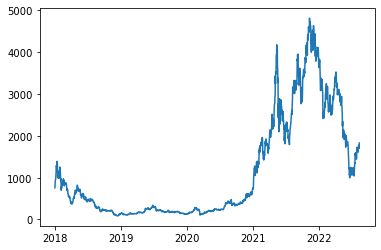

In [23]:
# convert data to float and plot
all_data = all_data.astype(float)
plt.plot(all_data['close'])

In [11]:
 print("There are " + str(all_data[:'2021'].shape[0]) + " observations in the training data")
print("There are " + str(all_data['2022':].shape[0]) + " observations in the test data")

There are 1462 observations in the training data
There are 221 observations in the test data


In [12]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 10, 1)
X_train.shape[0], X_train.shape[1]

(1451, 10)

In [13]:
# Convert the 3-D shape of X_train to a data frame so we can see:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
train_market_date = pd.concat([X_train_see, y_train_see], axis=1)
print("Train market data")
train_market_date.tail()

Train market data


,0,1,2,3,4,5,6,7,8,9,0
1446,0.802600,0.820489,0.812913,0.817271,0.831966,0.824633,0.852553,0.838784,0.849044,0.842425,0.836851
1447,0.820489,0.812913,0.817271,0.831966,0.824633,0.852553,0.838784,0.849044,0.842425,0.836851,0.785101
1448,0.812913,0.817271,0.831966,0.824633,0.852553,0.838784,0.849044,0.842425,0.836851,0.785101,0.750691
1449,0.817271,0.831966,0.824633,0.852553,0.838784,0.849044,0.842425,0.836851,0.785101,0.750691,0.767430
1450,0.831966,0.824633,0.852553,0.838784,0.849044,0.842425,0.836851,0.785101,0.750691,0.767430,0.760437


In [14]:
# Convert the 3-D shape of X_test to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
test_market_date = pd.DataFrame(X_test_see)
print("Test market data")
test_market_date.tail()

Test market data


,0,1,2,3,4,5,6,7,8,9
215,0.289013,0.328516,0.347308,0.346707,0.341483,0.337486,0.327360,0.327493,0.324794,0.322635
216,0.328516,0.347308,0.346707,0.341483,0.337486,0.327360,0.327493,0.324794,0.322635,0.349910
217,0.347308,0.346707,0.341483,0.337486,0.327360,0.327493,0.324794,0.322635,0.349910,0.340128
218,0.346707,0.341483,0.337486,0.327360,0.327493,0.324794,0.322635,0.349910,0.340128,0.342158
219,0.341483,0.337486,0.327360,0.327493,0.324794,0.322635,0.349910,0.340128,0.342158,0.358427


In [15]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1451 samples in the training data
There are 220 samples in the test data


In [18]:
# GRU Predictiion
my_GRU_model, GRU_predictions = GRU_model(X_train, y_train, X_test, sc)
len(GRU_predictions)

7/7 [==============================] - 4s 13ms/step


220

In [17]:
GRU_predictions

array([[3816.6287],
       [3809.1526],
       [3811.9026],
       [3816.88  ],
       [3793.888 ],
       [3736.1938],
       [3643.4885],
       [3528.4624],
       [3424.0452],
       [3338.7874],
       [3291.61  ],
       [3291.0344],
       [3304.1194],
       [3321.4734],
       [3341.4485],
       [3362.068 ],
       [3365.727 ],
       [3349.2595],
       [3314.1606],
       [3264.8577],
       [3165.3064],
       [3021.8918],
       [2885.713 ],
       [2770.2202],
       [2683.6228],
       [2625.3335],
       [2585.9685],
       [2571.5837],
       [2581.9756],
       [2605.4792],
       [2641.7227],
       [2691.3337],
       [2731.4888],
       [2758.4446],
       [2806.2961],
       [2872.8745],
       [2945.622 ],
       [3019.0886],
       [3081.6616],
       [3142.2744],
       [3178.0598],
       [3173.5288],
       [3143.433 ],
       [3100.3508],
       [3062.6235],
       [3066.0647],
       [3094.0803],
       [3101.6233],
       [3073.7434],
       [3023.6536],


In [19]:
# Get predictions
preds  = predict_future_days(all_data, 10, 30, my_GRU_model, sc)

Before transformation Input data for prediction
[[1630.28 1630.91 1618.16 1607.96 1736.81 1690.6  1700.19 1777.05 1702.76
  1826.73]]
Input data for prediction
[[0.32735986]
 [0.32749322]
 [0.32479436]
 [0.32263527]
 [0.34990961]
 [0.34012811]
 [0.34215807]
 [0.35842742]
 [0.34270208]
 [0.36894344]]
[0.327359860463738, 0.32749321581128743, 0.32479435758707265, 0.3226352710077008, 0.3499096147088832, 0.34012810580370945, 0.3421580705386287, 0.3584274229396599, 0.3427020756865684, 0.3689434446321298]
input [0.327359860463738, 0.32749321581128743, 0.32479435758707265, 0.3226352710077008, 0.3499096147088832, 0.34012810580370945, 0.3421580705386287, 0.3584274229396599, 0.3427020756865684, 0.3689434446321298] 
0 day input [[[0.32735986]
  [0.32749322]
  [0.32479436]
  [0.32263527]
  [0.34990961]
  [0.34012811]
  [0.34215807]
  [0.35842742]
  [0.34270208]
  [0.36894344]]]
0 day output [[0.3499822]]
1 day input [0.32749322 0.32479436 0.32263527 0.34990961 0.34012811 0.34215807
 0.35842742 0.34

In [20]:
# Get the Mean Squared Error
actual_pred = pd.DataFrame(columns=['close', 'prediction'])
actual_pred['close'] = all_data.loc['2022':, 'close'][0:len(GRU_predictions)]
actual_pred['prediction'] = GRU_predictions[:, 0]

m = MeanSquaredError()
m.update_state(np.array(actual_pred['close']), np.array(actual_pred['prediction']))

print("Mean Squared Error: " + str(m.result().numpy()))

Mean Squared Error: 30305.725


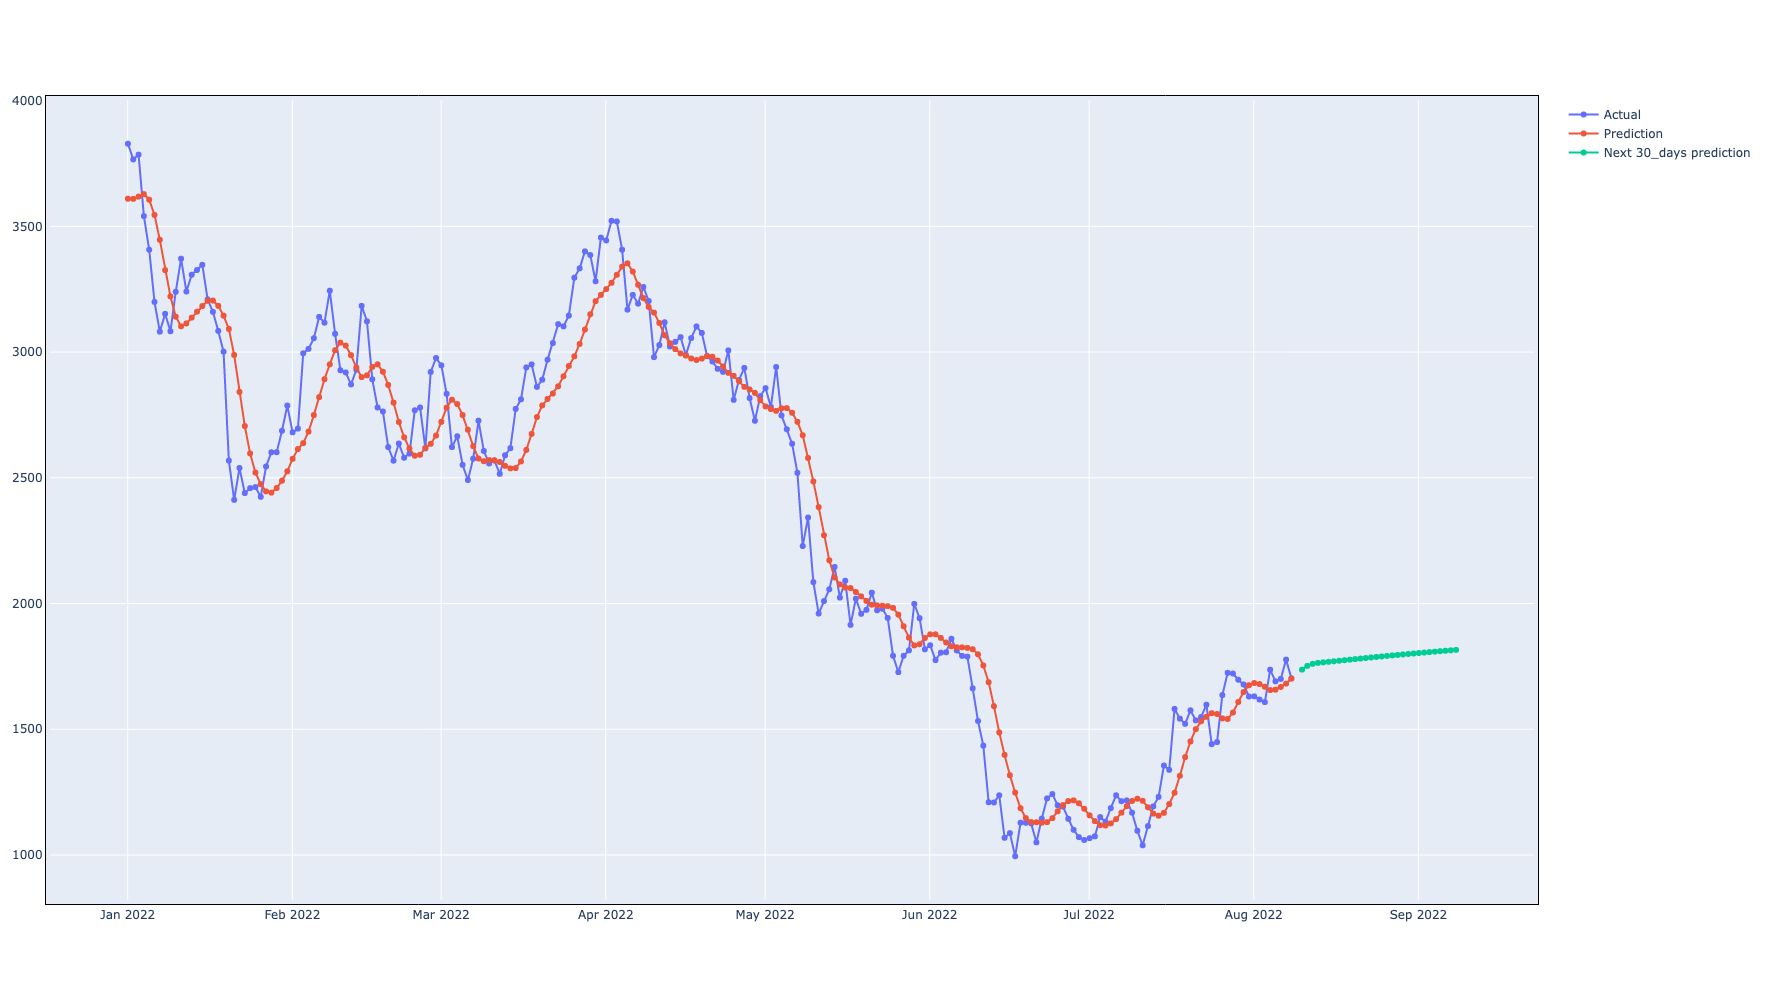

In [40]:
# Display chart
trace_close = go.Scatter(x=actual_pred.index, y=actual_pred['close'], mode='lines+markers', name='Actual')
trace_prediction = go.Scatter(x=actual_pred.index, y=actual_pred['prediction'], mode='lines+markers', name='Prediction')
trace_next_30days_prediction = go.Scatter(x=preds.index, y=preds['close'], mode='lines+markers', name='Next 30_days prediction')

# Fill out data with our traces
data = [trace_close, trace_prediction, trace_next_30days_prediction]
layout = go.Layout(
    autosize=False,
    width=2000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)
fig = go.Figure(data=data, layout=layout)
# Plot it and save as basic-line.html
pyo.iplot(fig, filename = 'chart')

In [49]:
# LSTM Predictiion
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
len(LSTM_prediction)

7/7 [==============================] - 1s 10ms/step


220

In [50]:
LSTM_prediction


array([[3677.5044],
       [3658.95  ],
       [3649.361 ],
       [3649.8054],
       [3630.3547],
       [3588.2925],
       [3513.803 ],
       [3415.375 ],
       [3321.8433],
       [3234.135 ],
       [3177.4204],
       [3159.7285],
       [3154.5881],
       [3165.7952],
       [3185.6118],
       [3209.27  ],
       [3216.8494],
       [3207.824 ],
       [3181.8958],
       [3139.931 ],
       [3050.335 ],
       [2928.9934],
       [2813.2239],
       [2703.0125],
       [2611.1086],
       [2541.1711],
       [2488.4016],
       [2463.2593],
       [2462.8787],
       [2477.6995],
       [2507.7551],
       [2550.9854],
       [2586.58  ],
       [2615.9294],
       [2666.7344],
       [2726.523 ],
       [2789.9993],
       [2857.4016],
       [2918.026 ],
       [2980.7722],
       [3020.1423],
       [3027.3784],
       [3012.9712],
       [2981.0813],
       [2949.5588],
       [2948.0364],
       [2958.9292],
       [2954.8057],
       [2931.6006],
       [2897.9697],


In [51]:
# Get predictions
preds  = predict_future_days(all_data, 10, 30, my_LSTM_model, sc)

Before transformation Input data for prediction
[[1630.28 1630.91 1618.16 1607.96 1736.81 1690.6  1700.19 1777.05 1702.76
  1826.73]]
Input data for prediction
[[0.32735986]
 [0.32749322]
 [0.32479436]
 [0.32263527]
 [0.34990961]
 [0.34012811]
 [0.34215807]
 [0.35842742]
 [0.34270208]
 [0.36894344]]
[0.327359860463738, 0.32749321581128743, 0.32479435758707265, 0.3226352710077008, 0.3499096147088832, 0.34012810580370945, 0.3421580705386287, 0.3584274229396599, 0.3427020756865684, 0.3689434446321298]
input [0.327359860463738, 0.32749321581128743, 0.32479435758707265, 0.3226352710077008, 0.3499096147088832, 0.34012810580370945, 0.3421580705386287, 0.3584274229396599, 0.3427020756865684, 0.3689434446321298] 
0 day input [[[0.32735986]
  [0.32749322]
  [0.32479436]
  [0.32263527]
  [0.34990961]
  [0.34012811]
  [0.34215807]
  [0.35842742]
  [0.34270208]
  [0.36894344]]]
0 day output [[0.34145778]]
1 day input [0.32749322 0.32479436 0.32263527 0.34990961 0.34012811 0.34215807
 0.35842742 0.3

In [53]:
# Get the Mean Squared Error
actual_pred = pd.DataFrame(columns=['close', 'prediction'])
actual_pred['close'] = all_data.loc['2022':, 'close'][0:len(LSTM_prediction)]
actual_pred['prediction'] = LSTM_prediction[:, 0]

m = MeanSquaredError()
m.update_state(np.array(actual_pred['close']), np.array(actual_pred['prediction']))

print("Mean Squared Error: " + str(m.result().numpy()))

Mean Squared Error: 36232.15


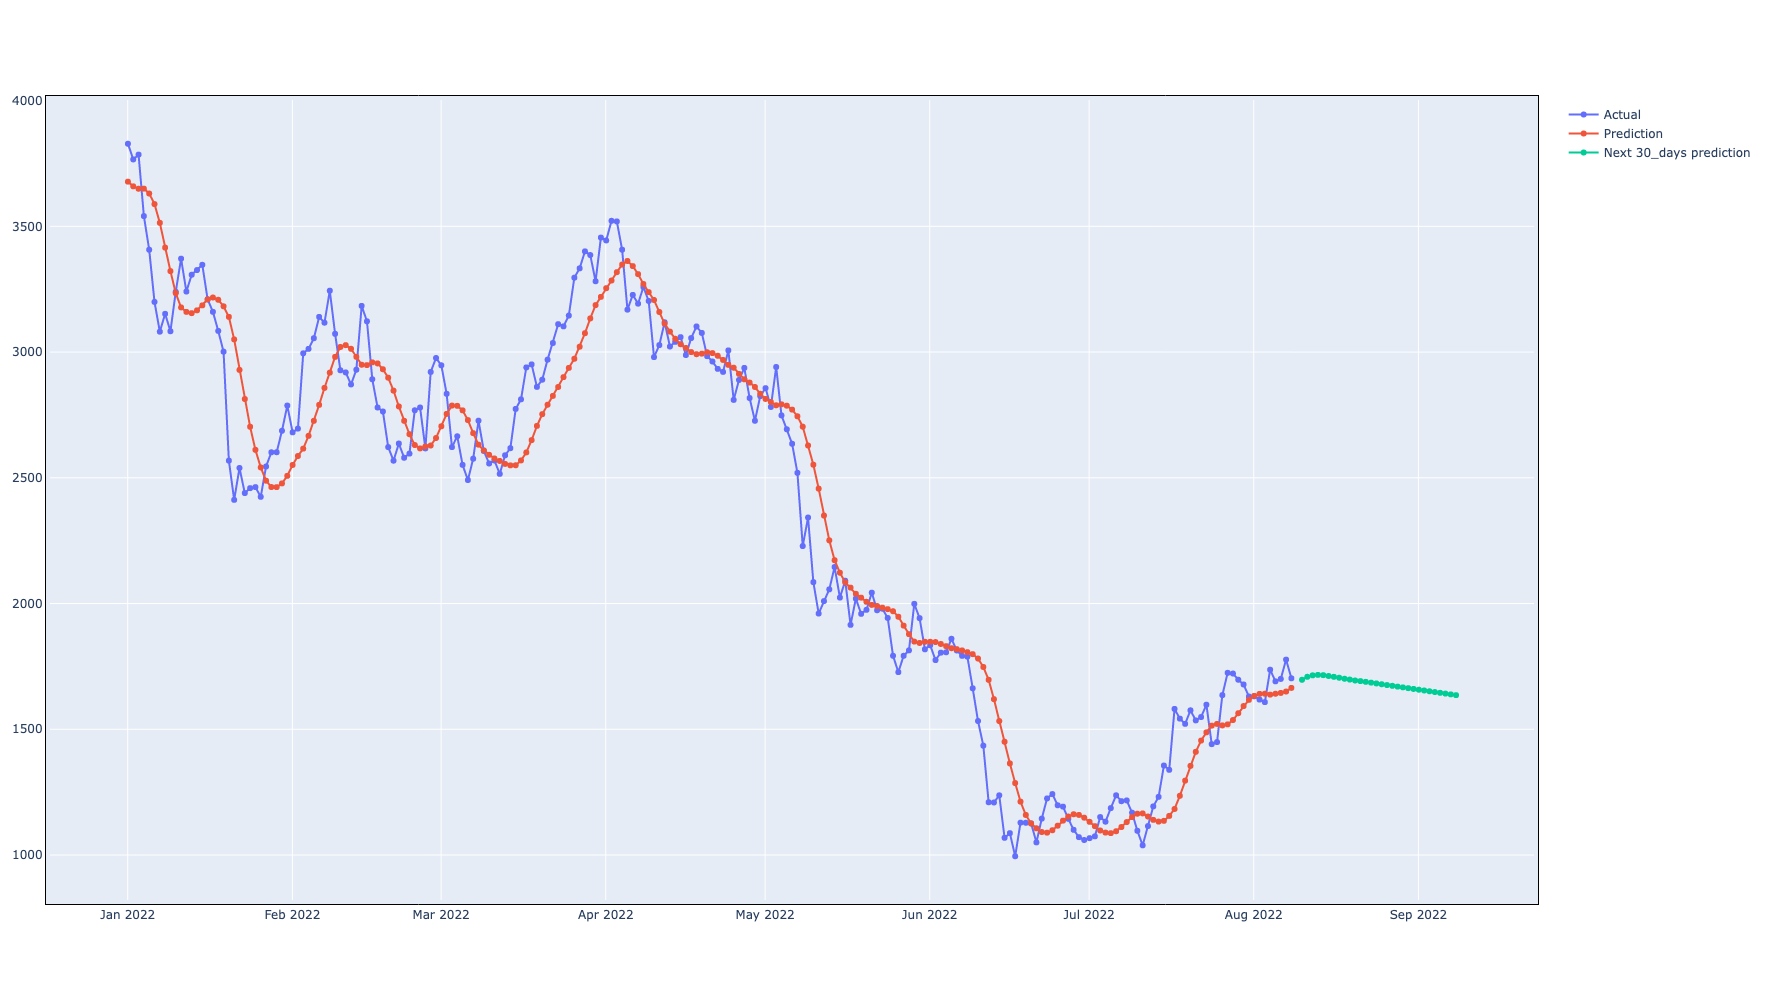

In [54]:
# Display Chart
trace_close = go.Scatter(x=actual_pred.index, y=actual_pred['close'], mode='lines+markers', name='Actual')
trace_prediction = go.Scatter(x=actual_pred.index, y=actual_pred['prediction'], mode='lines+markers', name='Prediction')
trace_next_30days_prediction = go.Scatter(x=preds.index, y=preds['close'], mode='lines+markers', name='Next 30_days prediction')

# Fill out data with our traces
data = [trace_close, trace_prediction, trace_next_30days_prediction]
layout = go.Layout(
    autosize=False,
    width=2000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)
fig = go.Figure(data=data, layout=layout)
# Plot it and save as basic-line.html
pyo.iplot(fig, filename = 'chart')